# **Deepfake detection 📹**
---

The project focuses on developing and evaluating models for detecting artificially created or modified video intended to mimic actual human.

---

# **1. Installing Dependencies 📚**


In [ ]:
!pip install numpy pandas matplotlib tensorflow ffmpeg-python

In [ ]:
!pip install kaggle opencv-python tensorflow ffmpeg-python -q MTCNN

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.9 MB/s eta 0:00:00


In [ ]:
!pip install mediapipe

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import json
import random
from tensorflow.keras import layers, models
import cv2
import os
import mediapipe as mp
import matplotlib.pyplot as plt
import subprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import EfficientNetB2, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed, LSTM, Input, GRU
    , GlobalAveragePooling2D, Bidirectional, BatchNormalization
)
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from multiprocessing import Pool
from IPython.display import Image
from transformers import pipeline
from google.colab import files

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Input, SpatialDropout3D, GlobalAveragePooling3D
)
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.activations import swish

# **Load Data 📂**

---

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shahadadel","key":"2df9bffb703a495078df78ade6084be8"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c deepfake-detection-challenge

100% 4.13G/4.13G [03:23<00:00, 23.6MB/s]
100% 4.13G/4.13G [03:23<00:00, 21.8MB/s]


In [ ]:
!unzip deepfake-detection-challenge.zip

# **Dataset Paths 🗂️**

---

In [ ]:
if not os.path.exists('deepfake_dataset'):
    os.makedirs('deepfake_dataset')
    print("Directory 'deepfake_dataset' created successfully.")
else:
    print("Directory 'deepfake_dataset' already exists.")

Directory 'deepfake_dataset' created successfully.


In [ ]:
dataset_path = 'deepfake_dataset/'
metadata_file = os.path.join(dataset_path, 'train_sample_videos', 'metadata.json')
video_dir = os.path.join(dataset_path, 'train_sample_videos')

In [ ]:
metadata_file = 'deepfake_dataset/train_sample_videos/metadata.json'

In [ ]:
!mv /content/train_sample_videos /content/deepfake_dataset

In [ ]:
with open(metadata_file, 'r') as f:
    metadata = json.load(f)

print(f"Metadata loaded successfully. Number of videos: {len(metadata)}")

Metadata loaded successfully. Number of videos: 400


# **Preprocessing 🔎**
---

**Function to extract features and detect faces**

In [ ]:
frames_dir = 'processed_frames'
faces_dir = 'processed_faces'
os.makedirs(frames_dir, exist_ok=True)
os.makedirs(faces_dir, exist_ok=True)

**We tried running the data with the full dataset but it took too long, so instead we will take a subset of it.**

In [ ]:
NUM_VIDEOS = 15
video_subset = random.sample(list(metadata.keys()), NUM_VIDEOS)

**We used mediapipe to extract the frames, detected the faces and save them.**

In [ ]:
def process_video_with_logging_and_showcase_mediapipe(video_name, video_dir, frames_dir, faces_dir, frame_rate=1):
    video_path = os.path.join(video_dir, video_name)
    log = {
        "video_name": video_name,
        "frames_extracted": 0,
        "faces_detected": 0,
        "status": "Success",
        "error": None
    }

    try:
        # Step 1: Extract frames
        cap = cv2.VideoCapture(video_path)
        frame_count = 0
        extracted_frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if frame_count % frame_rate == 0:
                filename = os.path.join(frames_dir, f"{video_name}_frame_{frame_count}.jpg")
                cv2.imwrite(filename, frame)
                log["frames_extracted"] += 1
                extracted_frames.append((filename, frame))
            frame_count += 1
        cap.release()
        print(f"Extracted {log['frames_extracted']} frames from {video_name}.")

        # Step 2: Detect faces with MediapipeN
        mp_face_detection = mp.solutions.face_detection
        with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
            frame_with_faces = None  # Store one frame with detected faces to showcase
            for frame_idx, (img_path, img) in enumerate(extracted_frames):
                rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                results = face_detection.process(rgb_img)

                # Draw rectangles around detected faces
                if results.detections:
                    log["faces_detected"] += len(results.detections)
                    for detection in results.detections:
                        bboxC = detection.location_data.relative_bounding_box
                        ih, iw, _ = img.shape
                        x, y, w, h = (
                            int(bboxC.xmin * iw),
                            int(bboxC.ymin * ih),
                            int(bboxC.width * iw),
                            int(bboxC.height * ih),
                        )
                        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

                        # Save detected face
                        face = img[y : y + h, x : x + w]
                        face_resized = cv2.resize(face, (300, 300))
                        face_output_path = os.path.join(
                            faces_dir, f"{video_name}_frame_{frame_idx}_face.jpg"
                        )
                        cv2.imwrite(face_output_path, face_resized)

                # Store the first frame with detected faces for showcasing
                if frame_with_faces is None and results.detections:
                    frame_with_faces = img

        print(f"Detected {log['faces_detected']} faces in {video_name}.")

        # Showcase the frame with detected faces
        if frame_with_faces is not None:
            print("Displaying one frame with detected faces...")
            plt.imshow(cv2.cvtColor(frame_with_faces, cv2.COLOR_BGR2RGB))
            plt.axis("off")
            plt.title(f"Frame with Detected Faces: {video_name}")
            plt.show()

    except Exception as e:
        log["status"] = "Failed"
        log["error"] = str(e)
        print(f"Error processing video {video_name}: {e}")

    return log

**Running the fuction to all the video in the subset**

In [ ]:
def process_videos_with_logging_and_showcase_mediapipe(video_subset, video_dir, frames_dir, faces_dir):
    all_logs = []
    for video_name in video_subset:
        print(f"\nProcessing video: {video_name}")
        video_log = process_video_with_logging_and_showcase_mediapipe(
            video_name, video_dir, frames_dir, faces_dir
        )
        all_logs.append(video_log)
        print(f"Results for {video_name}: {video_log}")
    return all_logs


Processing video: bwhlgysghg.mp4
Extracted 300 frames from bwhlgysghg.mp4.
Detected 300 faces in bwhlgysghg.mp4.
Displaying one frame with detected faces...


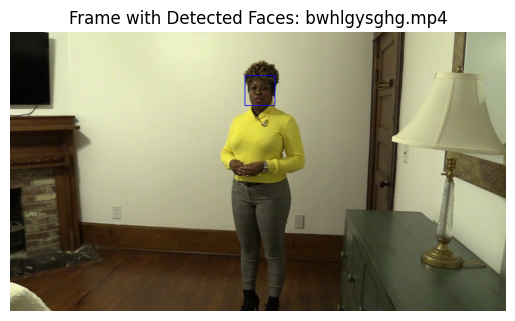

Results for bwhlgysghg.mp4: {'video_name': 'bwhlgysghg.mp4', 'frames_extracted': 300, 'faces_detected': 300, 'status': 'Success', 'error': None}

Processing video: cknyxaqouy.mp4
Extracted 300 frames from cknyxaqouy.mp4.
Detected 300 faces in cknyxaqouy.mp4.
Displaying one frame with detected faces...


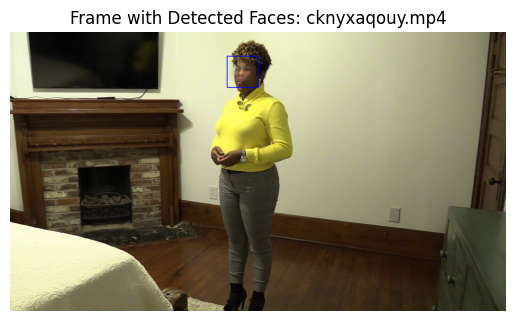

Results for cknyxaqouy.mp4: {'video_name': 'cknyxaqouy.mp4', 'frames_extracted': 300, 'faces_detected': 300, 'status': 'Success', 'error': None}

Processing video: cwbacdwrzo.mp4
Extracted 300 frames from cwbacdwrzo.mp4.
Detected 300 faces in cwbacdwrzo.mp4.
Displaying one frame with detected faces...


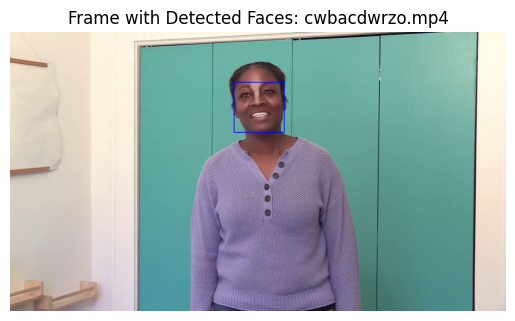

Results for cwbacdwrzo.mp4: {'video_name': 'cwbacdwrzo.mp4', 'frames_extracted': 300, 'faces_detected': 300, 'status': 'Success', 'error': None}

Processing video: bmjzrlszhi.mp4
Extracted 300 frames from bmjzrlszhi.mp4.
Detected 300 faces in bmjzrlszhi.mp4.
Displaying one frame with detected faces...


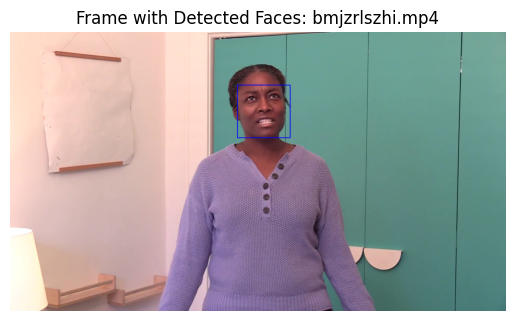

Results for bmjzrlszhi.mp4: {'video_name': 'bmjzrlszhi.mp4', 'frames_extracted': 300, 'faces_detected': 300, 'status': 'Success', 'error': None}

Processing video: bntlodcfeg.mp4
Extracted 300 frames from bntlodcfeg.mp4.
Detected 300 faces in bntlodcfeg.mp4.
Displaying one frame with detected faces...


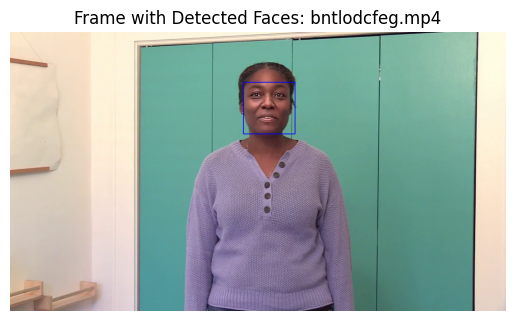

Results for bntlodcfeg.mp4: {'video_name': 'bntlodcfeg.mp4', 'frames_extracted': 300, 'faces_detected': 300, 'status': 'Success', 'error': None}

Processing video: chviwxsfhg.mp4
Extracted 300 frames from chviwxsfhg.mp4.
Detected 599 faces in chviwxsfhg.mp4.
Displaying one frame with detected faces...


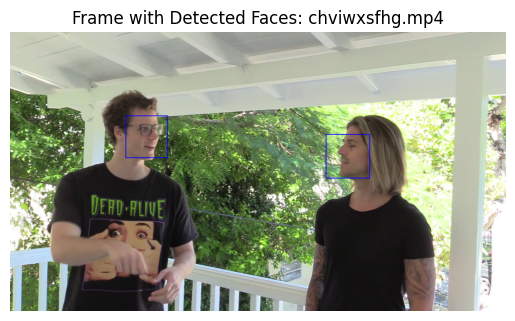

Results for chviwxsfhg.mp4: {'video_name': 'chviwxsfhg.mp4', 'frames_extracted': 300, 'faces_detected': 599, 'status': 'Success', 'error': None}

Processing video: blpchvmhxx.mp4
Extracted 300 frames from blpchvmhxx.mp4.
Detected 300 faces in blpchvmhxx.mp4.
Displaying one frame with detected faces...


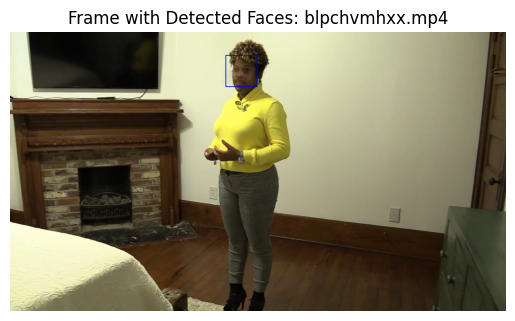

Results for blpchvmhxx.mp4: {'video_name': 'blpchvmhxx.mp4', 'frames_extracted': 300, 'faces_detected': 300, 'status': 'Success', 'error': None}

Processing video: bkvetcojbt.mp4
Extracted 300 frames from bkvetcojbt.mp4.
Detected 300 faces in bkvetcojbt.mp4.
Displaying one frame with detected faces...


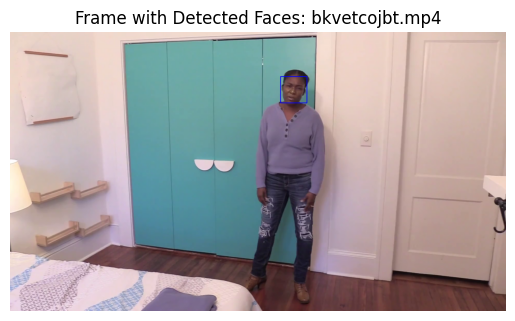

Results for bkvetcojbt.mp4: {'video_name': 'bkvetcojbt.mp4', 'frames_extracted': 300, 'faces_detected': 300, 'status': 'Success', 'error': None}

Processing video: avmjormvsx.mp4
Extracted 300 frames from avmjormvsx.mp4.
Detected 300 faces in avmjormvsx.mp4.
Displaying one frame with detected faces...


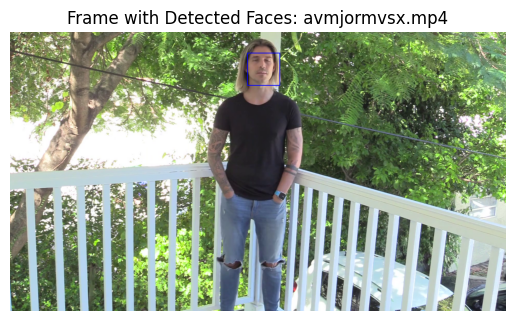

Results for avmjormvsx.mp4: {'video_name': 'avmjormvsx.mp4', 'frames_extracted': 300, 'faces_detected': 300, 'status': 'Success', 'error': None}

Processing video: cfyduhpbps.mp4
Extracted 300 frames from cfyduhpbps.mp4.
Detected 300 faces in cfyduhpbps.mp4.
Displaying one frame with detected faces...


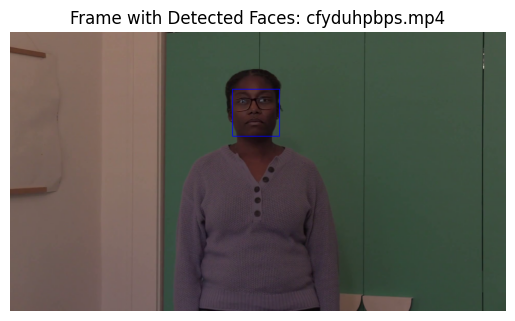

Results for cfyduhpbps.mp4: {'video_name': 'cfyduhpbps.mp4', 'frames_extracted': 300, 'faces_detected': 300, 'status': 'Success', 'error': None}

Processing video: caifxvsozs.mp4
Extracted 300 frames from caifxvsozs.mp4.
Detected 569 faces in caifxvsozs.mp4.
Displaying one frame with detected faces...


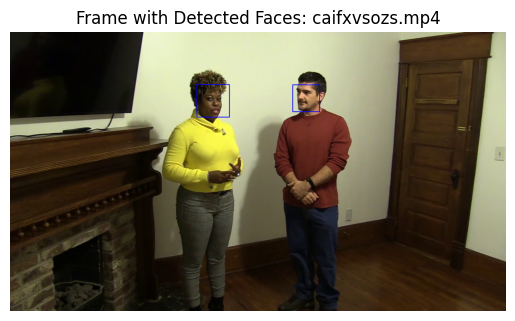

Results for caifxvsozs.mp4: {'video_name': 'caifxvsozs.mp4', 'frames_extracted': 300, 'faces_detected': 569, 'status': 'Success', 'error': None}

Processing video: aagfhgtpmv.mp4
Extracted 300 frames from aagfhgtpmv.mp4.
Detected 300 faces in aagfhgtpmv.mp4.
Displaying one frame with detected faces...


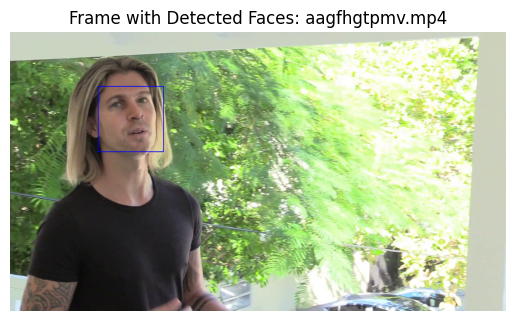

Results for aagfhgtpmv.mp4: {'video_name': 'aagfhgtpmv.mp4', 'frames_extracted': 300, 'faces_detected': 300, 'status': 'Success', 'error': None}

Processing video: apatcsqejh.mp4
Extracted 300 frames from apatcsqejh.mp4.
Detected 600 faces in apatcsqejh.mp4.
Displaying one frame with detected faces...


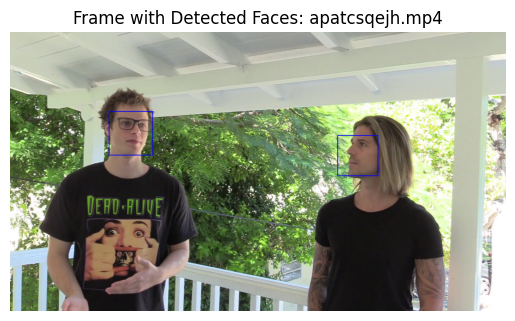

Results for apatcsqejh.mp4: {'video_name': 'apatcsqejh.mp4', 'frames_extracted': 300, 'faces_detected': 600, 'status': 'Success', 'error': None}

Processing video: cqrskwiqng.mp4
Extracted 300 frames from cqrskwiqng.mp4.
Detected 300 faces in cqrskwiqng.mp4.
Displaying one frame with detected faces...


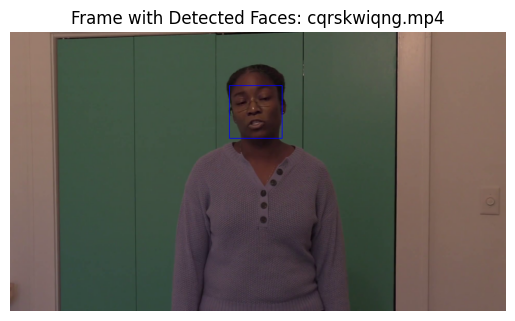

Results for cqrskwiqng.mp4: {'video_name': 'cqrskwiqng.mp4', 'frames_extracted': 300, 'faces_detected': 300, 'status': 'Success', 'error': None}

Processing video: egbbcxcuqy.mp4
Extracted 300 frames from egbbcxcuqy.mp4.
Detected 300 faces in egbbcxcuqy.mp4.
Displaying one frame with detected faces...


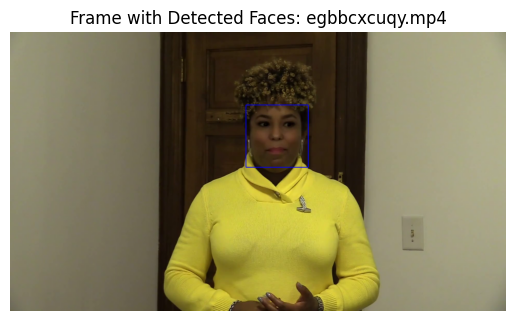

Results for egbbcxcuqy.mp4: {'video_name': 'egbbcxcuqy.mp4', 'frames_extracted': 300, 'faces_detected': 300, 'status': 'Success', 'error': None}


In [ ]:
video_logs = process_videos_with_logging_and_showcase_mediapipe(
    video_subset, video_dir, frames_dir, faces_dir
)


**Make the output clearer**

In [ ]:
print("\nSummary of Preprocessing:")
for log in video_logs:
    print(f"- Video: {log['video_name']}")
    print(f"  Frames Extracted: {log['frames_extracted']}")
    print(f"  Faces Detected: {log['faces_detected']}")
    print(f"  Status: {log['status']}")
    if log['error']:
        print(f"  Error: {log['error']}")
    print("-" * 50)


Summary of Preprocessing:
- Video: bwhlgysghg.mp4
  Frames Extracted: 300
  Faces Detected: 300
  Status: Success
--------------------------------------------------
- Video: cknyxaqouy.mp4
  Frames Extracted: 300
  Faces Detected: 300
  Status: Success
--------------------------------------------------
- Video: cwbacdwrzo.mp4
  Frames Extracted: 300
  Faces Detected: 300
  Status: Success
--------------------------------------------------
- Video: bmjzrlszhi.mp4
  Frames Extracted: 300
  Faces Detected: 300
  Status: Success
--------------------------------------------------
- Video: bntlodcfeg.mp4
  Frames Extracted: 300
  Faces Detected: 300
  Status: Success
--------------------------------------------------
- Video: chviwxsfhg.mp4
  Frames Extracted: 300
  Faces Detected: 599
  Status: Success
--------------------------------------------------
- Video: blpchvmhxx.mp4
  Frames Extracted: 300
  Faces Detected: 300
  Status: Success
--------------------------------------------------


In [ ]:
total_frames = 0
for log in video_logs:
  total_frames += log['frames_extracted']
print(f"\nTotal frames extracted across all processed videos: {total_frames}")


Total frames extracted across all processed videos: 4500


# **Exploring Data Analysis 📊**


---

In [ ]:
df = pd.DataFrame(metadata).transpose().reset_index()
df = df.rename(columns={'index': 'video_name'})

In [ ]:
df.head()

video_name label  split        original
0  aagfhgtpmv.mp4  FAKE  train  vudstovrck.mp4
1  aapnvogymq.mp4  FAKE  train  jdubbvfswz.mp4
2  abarnvbtwb.mp4  REAL  train            None
3  abofeumbvv.mp4  FAKE  train  atvmxvwyns.mp4
4  abqwwspghj.mp4  FAKE  train  qzimuostzz.mp4

In [ ]:
fake_df = df[df['label'] == 'FAKE']
real_df = df[df['label'] == 'REAL']

In [ ]:
print(f"Number of fake videos: {len(fake_df)}")
print(f"Number of real videos: {len(real_df)}")

Number of fake videos: 323
Number of real videos: 77


**Check for missing data.**

In [ ]:
def missing_data(data):
  total = data.isnull().sum()
  percent = (data.isnull().sum() / data.isnull().count() * 100)
  summary = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  summary['Types'] = [str(data[col].dtype) for col in data.columns]
  return summary

In [ ]:
missing_data(df)

Total  Percent   Types
video_name      0     0.00  object
label           0     0.00  object
split           0     0.00  object
original       77    19.25  object

From the table it's clear that we have 77 mising data 0r 19%. we can provide more analysis and check the real and fake labels to see the precentage of missing data from both.

In [ ]:
missing_data(df.loc[df.label == 'FAKE'])

Total  Percent   Types
video_name      0      0.0  object
label           0      0.0  object
split           0      0.0  object
original        0      0.0  object

In [ ]:
missing_data(df.loc[df.label == 'REAL'])

Total  Percent   Types
video_name      0      0.0  object
label           0      0.0  object
split           0      0.0  object
original       77    100.0  object

So all missing data is from the real label. there are a few methods we can do to solve this one of them is just removing them and i'm tempting to just do it, but instead we can augment the data and make sure the data is balanced.


**Checking pixel intensity**

In [ ]:
def pixel_intensity_from_frames(frames_dir, label, df, num_samples=10):
    frame_files = [f for f in os.listdir(frames_dir) if any(video in f for video in df[df['label'] == label]['video_name'].values)]
    sampled_frames = random.sample(frame_files, min(len(frame_files), num_samples))

    all_means = []
    all_stds = []

    for frame_file in sampled_frames:
        frame_path = os.path.join(frames_dir, frame_file)
        frame = cv2.imread(frame_path)

        if frame is not None:
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            all_means.append(np.mean(gray_frame))
            all_stds.append(np.std(gray_frame))
        else:
            print(f"Warning: Could not read frame {frame_path}")

    return all_means, all_stds


In [ ]:
real_means, real_stds = pixel_intensity_from_frames(frames_dir, "REAL", df, num_samples=10)
fake_means, fake_stds = pixel_intensity_from_frames(frames_dir, "FAKE", df, num_samples=10)

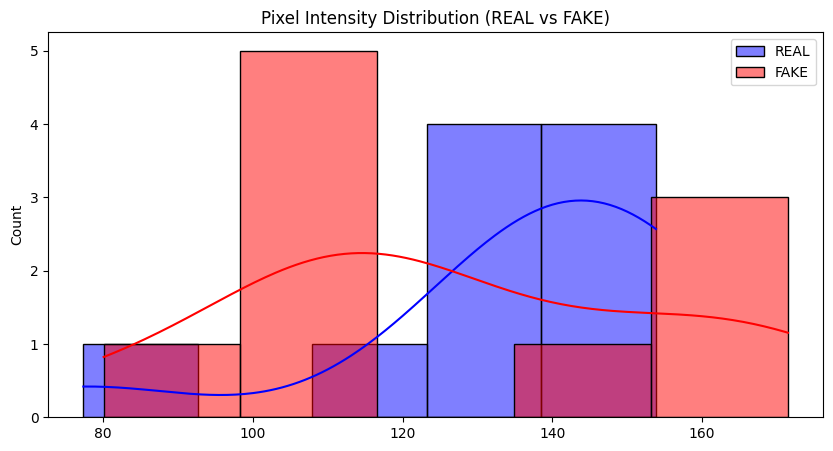

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(real_means, color="blue", label="REAL", kde=True)
sns.histplot(fake_means, color="red", label="FAKE", kde=True)
plt.legend()
plt.title("Pixel Intensity Distribution (REAL vs FAKE)")
plt.show()

The plot suggest that the real videos pixels are more  uniform and moderate, and they have narrower range, concentrated around lower pixel intensities.

The fake are more boareder and higher intensities, which suggest that they are extreme or unnatural pixel values in some regions.

however, we can see an overlap between them suggesting it's may not be the best feature to detect.

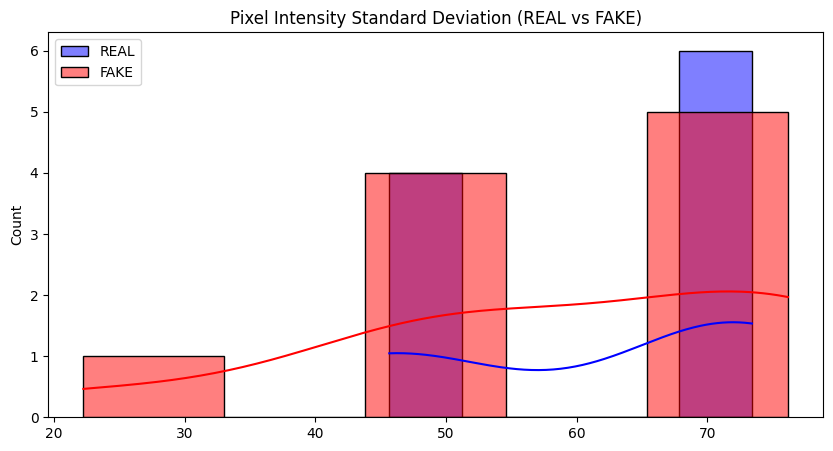

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(real_stds, color="blue", label="REAL", kde=True)
sns.histplot(fake_stds, color="red", label="FAKE", kde=True)
plt.legend()
plt.title("Pixel Intensity Standard Deviation (REAL vs FAKE)")
plt.show()

the plot suggests the pixel-level standard deviation could be a very informative feature for distinguishing real from fake images, because the real videos are more pixel-level variation and contrast compared to the fake images.

**Analyze facial landmarks and compare key metrics like face size and position using Mediapipe.**

In [ ]:
def analyze_face_from_frames(faces_dir, label, df, num_samples=10):
    face_files = [f for f in os.listdir(faces_dir) if any(video in f for video in df[df['label'] == label]['video_name'].values)]
    sampled_faces = random.sample(face_files, min(len(face_files), num_samples))

    face_sizes = []

    for face_file in sampled_faces:
        face_path = os.path.join(faces_dir, face_file)
        img = cv2.imread(face_path)

        if img is not None:
            with mp.solutions.face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1) as face_mesh:
                rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                results = face_mesh.process(rgb_img)

                if results.multi_face_landmarks:
                    for face_landmarks in results.multi_face_landmarks:
                        x_coords = [landmark.x for landmark in face_landmarks.landmark]
                        y_coords = [landmark.y for landmark in face_landmarks.landmark]
                        face_width = max(x_coords) - min(x_coords)
                        face_height = max(y_coords) - min(y_coords)
                        face_sizes.append(face_width * face_height)
        else:
            print(f"Warning: Could not read face image {face_path}")

    return face_sizes


In [ ]:
real_face_sizes = analyze_face_from_frames(faces_dir, "REAL", df, num_samples=10)
fake_face_sizes = analyze_face_from_frames(faces_dir, "FAKE", df, num_samples=10)

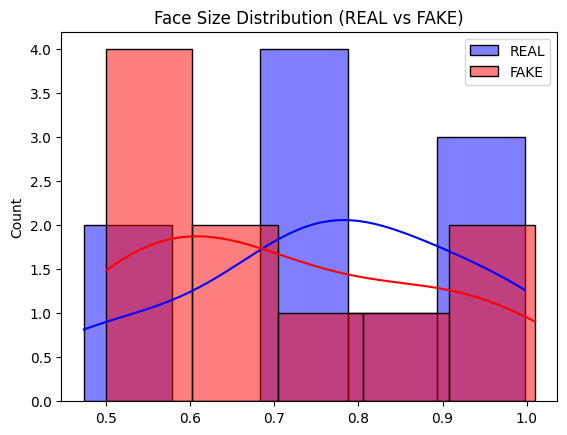

In [ ]:
sns.histplot(real_face_sizes, color="blue", label="REAL", kde=True)
sns.histplot(fake_face_sizes, color="red", label="FAKE", kde=True)
plt.legend()
plt.title("Face Size Distribution (REAL vs FAKE)")
plt.show()

The plot tell us that real frames mostly have smaller face compared to fake frames,  with minimal overlap. This implies that the face size could be a potentially useful feature for distinguishing real from fake images in a deep fake detection system.

In [ ]:
real_frame_count = 0
fake_frame_count = 0

In [ ]:
import matplotlib.cm as cm

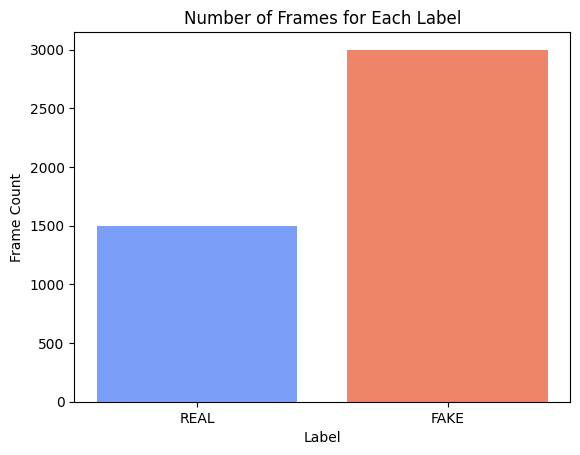

REAL frames: 1500
FAKE frames: 3000


In [ ]:
for frame_file in os.listdir(frames_dir):
    video_name = "_".join(frame_file.split("_")[:1])

    if video_name in df['video_name'].values:
        label = df[df['video_name'] == video_name]['label'].values[0]

        if label == 'REAL':
            real_frame_count += 1
        elif label == 'FAKE':
            fake_frame_count += 1
    else:
        print(f"Warning: Frame file {frame_file} does not have a matching video_name in metadata.")

frame_counts = {'REAL': real_frame_count, 'FAKE': fake_frame_count}
plt.bar(frame_counts.keys(), frame_counts.values(), color=cm.coolwarm([0.2, 0.8]))
plt.title("Number of Frames for Each Label")
plt.ylabel("Frame Count")
plt.xlabel("Label")
plt.show()

print(f"REAL frames: {real_frame_count}")
print(f"FAKE frames: {fake_frame_count}")


**Augmeting real label frams**

In [ ]:
augmented_real_dir = "augmented_real_frames"
os.makedirs(augmented_real_dir, exist_ok=True)

In [ ]:
real_videos = df[df['label'] == 'REAL']['video_name'].values
real_frame_files = [os.path.join(frames_dir, f) for f in os.listdir(frames_dir) if any(video in f for video in real_videos)]

In [ ]:
fake_videos = df[df['label'] == 'FAKE']['video_name'].values
fake_frame_files = [os.path.join(frames_dir, f) for f in os.listdir(frames_dir) if any(video in f for video in fake_videos)]

In [ ]:
frames_real = fake_frame_count - real_frame_count
frames_real

1500

In [ ]:
def augment_frames(frame_file, output_dir, num_augments):
    augmentations = ['flip', 'brightness', 'blur']
    augmented_count = 0

    frame_name = os.path.basename(frame_file)
    img = cv2.imread(frame_file)

    while augmented_count < num_augments:
        aug_type = random.choice(augmentations)

        if aug_type == 'flip':
            augmented_img = cv2.flip(img, 1)
        elif aug_type == 'brightness':
            alpha = random.uniform(0.8, 1.5)
            beta = random.randint(-50, 50)
            augmented_img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
        elif aug_type == 'blur':
            ksize = random.choice([3, 5, 7])
            augmented_img = cv2.GaussianBlur(img, (ksize, ksize), 0)
        else:
            continue

        output_path = os.path.join(output_dir, f"{aug_type}_{augmented_count}_{frame_name}")
        cv2.imwrite(output_path, augmented_img)
        augmented_count += 1


In [ ]:
framesAug = 0
for frame_file in fake_frame_files:
    if framesAug >= frames_real:
        break
    augment_frames(frame_file, augmented_real_dir, num_augments=1)
    framesAug += 1
print(f"Augmented {framesAug} frames. Total REAL frames now: {real_frame_count + framesAug}")

Augmented 1500 frames. Total REAL frames now: 3000


In [ ]:
final_real_frame_count = real_frame_count + framesAug
fake_frame_count = len([f for f in os.listdir(frames_dir) if any(video in f for video in df[df['label'] == 'FAKE']['video_name'].values)])

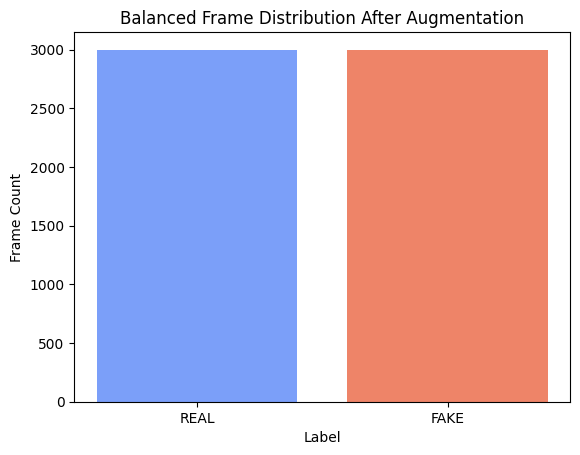

In [ ]:
frame_counts = {'REAL': final_real_frame_count, 'FAKE': fake_frame_count}
plt.bar(frame_counts.keys(), frame_counts.values(), color=cm.coolwarm([0.2, 0.8]))
plt.title("Balanced Frame Distribution After Augmentation")
plt.ylabel("Frame Count")
plt.xlabel("Label")
plt.show()

In [ ]:
print(f"REAL frames: {final_real_frame_count}")
print(f"FAKE frames: {fake_frame_count}")

REAL frames: 3000
FAKE frames: 3000


In [ ]:
augmented_real_files = [os.path.join(augmented_real_dir, f) for f in os.listdir(augmented_real_dir)]
augmented_real_files

In [ ]:
real_labels = [0] * len(real_frame_files)
fake_labels = [1] * len(fake_frame_files)
augmented_labels = [0] * len(augmented_real_files)

In [ ]:
frame_files = real_frame_files + fake_frame_files + augmented_real_files
labels = real_labels + fake_labels + augmented_labels

In [ ]:
print(f"Total frames: {len(frame_files)}")
print(f"REAL frames: {len(real_frame_files) + len(augmented_real_files)}")
print(f"FAKE frames: {len(fake_frame_files)}")

Total frames: 6000
REAL frames: 3000
FAKE frames: 3000


In [ ]:
total_files = len(real_frame_files)
print(f"Total number of files in the folder: {total_files}")

Total number of files in the folder: 1500


**In ths function we tried to mix up real and fake to make the model more generalized, however the outcome images were not great so we did not add them.**

In [ ]:
def mixup_and_plot(real_frame_files, fake_frame_files, alpha=0.2):
    real_frame_path = random.choice(real_frame_files)
    fake_frame_path = random.choice(fake_frame_files)

    x1 = cv2.imread(real_frame_path)
    x2 = cv2.imread(fake_frame_path)

    if x1 is None or x2 is None:
        print("Error: Could not read one of the images.")
        return

    x1 = x1.astype(np.float32) / 255.0
    x2 = x2.astype(np.float32) / 255.0

    lam = np.random.beta(alpha, alpha)
    x_mixed = lam * x1 + (1 - lam) * x2

    x_mixed = (x_mixed * 255).astype(np.uint8)

    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(x_mixed, cv2.COLOR_BGR2RGB))
    plt.title(f"Mixup Image (λ = {lam:.2f})")
    plt.axis("off")
    plt.show()

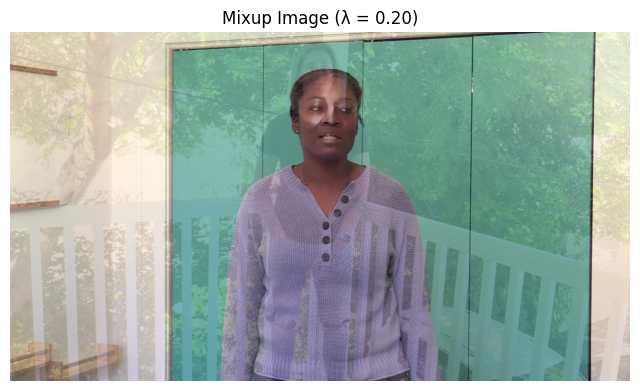

In [ ]:
mixup_and_plot(real_frame_files, fake_frame_files, alpha=0.9)

Now the data is balanced. we can do other analysis.

**Color Analysis**

In [ ]:
def color_analysis(frames_dir, df, label):
  video_names = df[df['label'] == label]['video_name'].values
  frame_files = [os.path.join(frames_dir, f) for f in os.listdir(frames_dir) if any(video in f for video in video_names)]
  reds, greens, blues = [], [], []

  for frame_file in frame_files:
    img = cv2.imread(frame_file)
    reds.append(np.mean(img[:, :, 2]))
    greens.append(np.mean(img[:, :, 1]))
    blues.append(np.mean(img[:, :, 0]))

  return reds, greens, blues

In [ ]:
Rred, Rgreen, Rblue = color_analysis(frames_dir, df, "REAL")
Fred, Fgreen, Fblue = color_analysis(frames_dir, df, "FAKE")

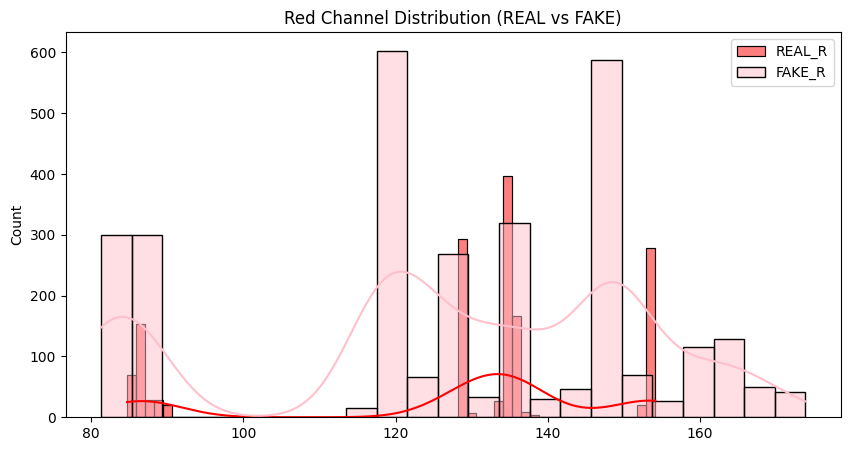

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(Rred, color="red", label="REAL_R", kde=True)
sns.histplot(Fred, color="pink", label="FAKE_R", kde=True)
plt.legend()
plt.title("Red Channel Distribution (REAL vs FAKE)")
plt.show()

**The plot shows that the real video have more narrow and uniform channel diribution than the fake videos. The fake video had extreme variability, suggesting potential manipulation.**

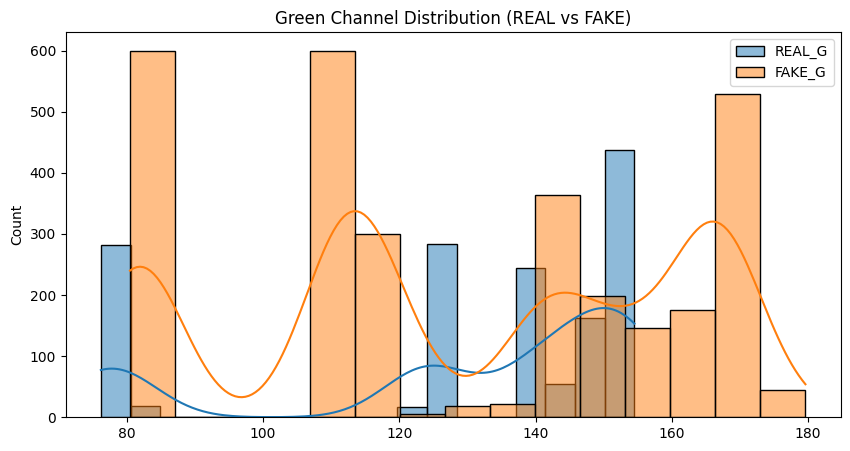

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(Rgreen, label="REAL_G", kde=True)
sns.histplot(Fgreen, label="FAKE_G", kde=True)
sns.color_palette("rocket", as_cmap=True)
plt.legend()
plt.title("Green Channel Distribution (REAL vs FAKE)")
plt.show()

**Same as the red plot, the fake videos had broader and more variable distribution compared to real videos.**

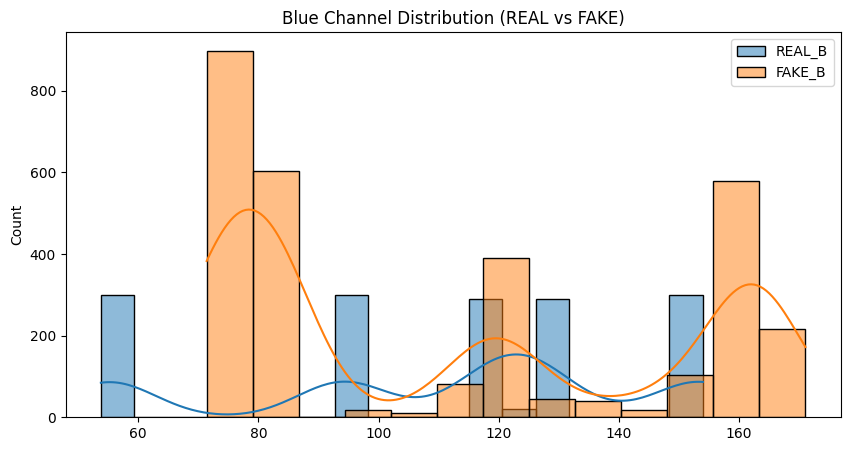

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(Rblue, label="REAL_B", kde=True)
sns.histplot(Fblue, label="FAKE_B", kde=True)
sns.color_palette("magma", as_cmap=True)
plt.legend()
plt.title("Blue Channel Distribution (REAL vs FAKE)")
plt.show()

**Same for the red and green, the fake had boarder range of values compared to the real video. Using all RGB features could be usefull to detect real and fake videos**

# **Splitting Data ✂️**

---

In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(frame_files, labels, test_size=0.5, stratify=labels, random_state=42)

In [ ]:
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [ ]:
print(f"Training set size: {len(x_train)}")
print(f"Validation set size: {len(x_val)}")
print(f"Test set size: {len(x_test)}")

Training set size: 3000
Validation set size: 1500
Test set size: 1500


**Data Generator**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)


In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({"filename": x_train, "class": [str(x) for x in y_train]}),
    x_col="filename",
    y_col="class",
    target_size = (224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=True
)

Found 3000 validated image filenames belonging to 2 classes.


In [ ]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({"filename": x_test, "class": [str(x) for x in y_test]}),
    x_col="filename",
    y_col="class",
    target_size = (224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

Found 1500 validated image filenames belonging to 2 classes.


In [ ]:
vali_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({"filename": x_val, "class": [str(x) for x in y_val]}),
    x_col="filename",
    y_col="class",
    target_size = (224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

Found 1500 validated image filenames belonging to 2 classes.


**After running the model we had an error and we found out that we need to reshape the data to (batch_size, num_frames, 224, 224, 3). The function processes multiple frames per video, normalizes the images, and organizes them into the required input shape.**

In [ ]:
def sequence_generator(file_paths, labels, batch_size=4, num_frames=5, img_size=(224, 224)):
    while True:
        # Shuffle the data
        data = list(zip(file_paths, labels))
        np.random.shuffle(data)
        file_paths, labels = zip(*data)

        for i in range(0, len(file_paths) - batch_size * num_frames, batch_size * num_frames):
            batch_sequences = []
            batch_labels = []

            for j in range(batch_size):

                sequence_files = file_paths[i + j * num_frames: i + (j + 1) * num_frames]
                label = labels[i + j * num_frames]

                sequence = []
                for file in sequence_files:
                    img = cv2.imread(file)
                    img = cv2.resize(img, img_size)
                    img = img / 255.0
                    sequence.append(img)

                batch_sequences.extend(sequence)
                batch_labels.append(label)

            batch_sequences = np.array(batch_sequences, dtype=np.float32)
            batch_sequences = batch_sequences.reshape(batch_size, num_frames, img_size[0], img_size[1], 3)  # Changed reshape order

            yield batch_sequences, np.array(batch_labels)

In [ ]:
train_sequence_gen = sequence_generator(x_train, y_train, batch_size=4, num_frames=20)
val_sequence_gen = sequence_generator(x_val, y_val, batch_size=4, num_frames=20)
test_sequence_gen = sequence_generator(x_test, y_test, batch_size=4, num_frames=20)

# **3D CNN Model 🧠**

---

In [ ]:
num_frames = 20
input_shape = (num_frames, 224, 224, 3)

In [ ]:
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 5), activation= swish , input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(SpatialDropout3D(0.2))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size=(3, 3, 5), activation= swish, padding='same'))
model.add(BatchNormalization())
model.add(SpatialDropout3D(0.2))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=(3, 3, 5), activation= swish, padding='same'))
model.add(BatchNormalization())
model.add(SpatialDropout3D(0.2))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(256, kernel_size=(3, 3, 5), activation= swish, padding='same'))
model.add(BatchNormalization())
model.add(SpatialDropout3D(0.2))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(GlobalAveragePooling3D())

model.add(Dense(256, activation=swish))
model.add(Dropout(0.5))
model.add(Dense(128, activation=swish))
model.add(Dropout(0.4))

model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# **Training 🚀**

In [ ]:
history = model.fit(
    train_sequence_gen,
    validation_data=val_sequence_gen,
    epochs=50,
    steps_per_epoch=32,
    validation_steps=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.6060 - loss: 0.6486 - val_accuracy: 0.4766 - val_loss: 0.7391 - learning_rate: 1.0000e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.4179 - loss: 0.8258 - val_accuracy: 0.4766 - val_loss: 0.8043 - learning_rate: 1.0000e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.5235 - loss: 0.7869 - val_accuracy: 0.5234 - val_loss: 0.7455 - learning_rate: 1.0000e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.5129 - loss: 0.7517 - val_accuracy: 0.4297 - val_loss: 0.8691 - learning_rate: 1.0000e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.4239 - loss: 0.8003 - val_accuracy: 0.4297 - val_loss: 0.8837 - learning_rate: 5.0000e-05
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.5221 - loss: 0.7257 - val_accuracy: 0.5547 - val_loss: 0.7794 - learning_rate: 5.0000e-05


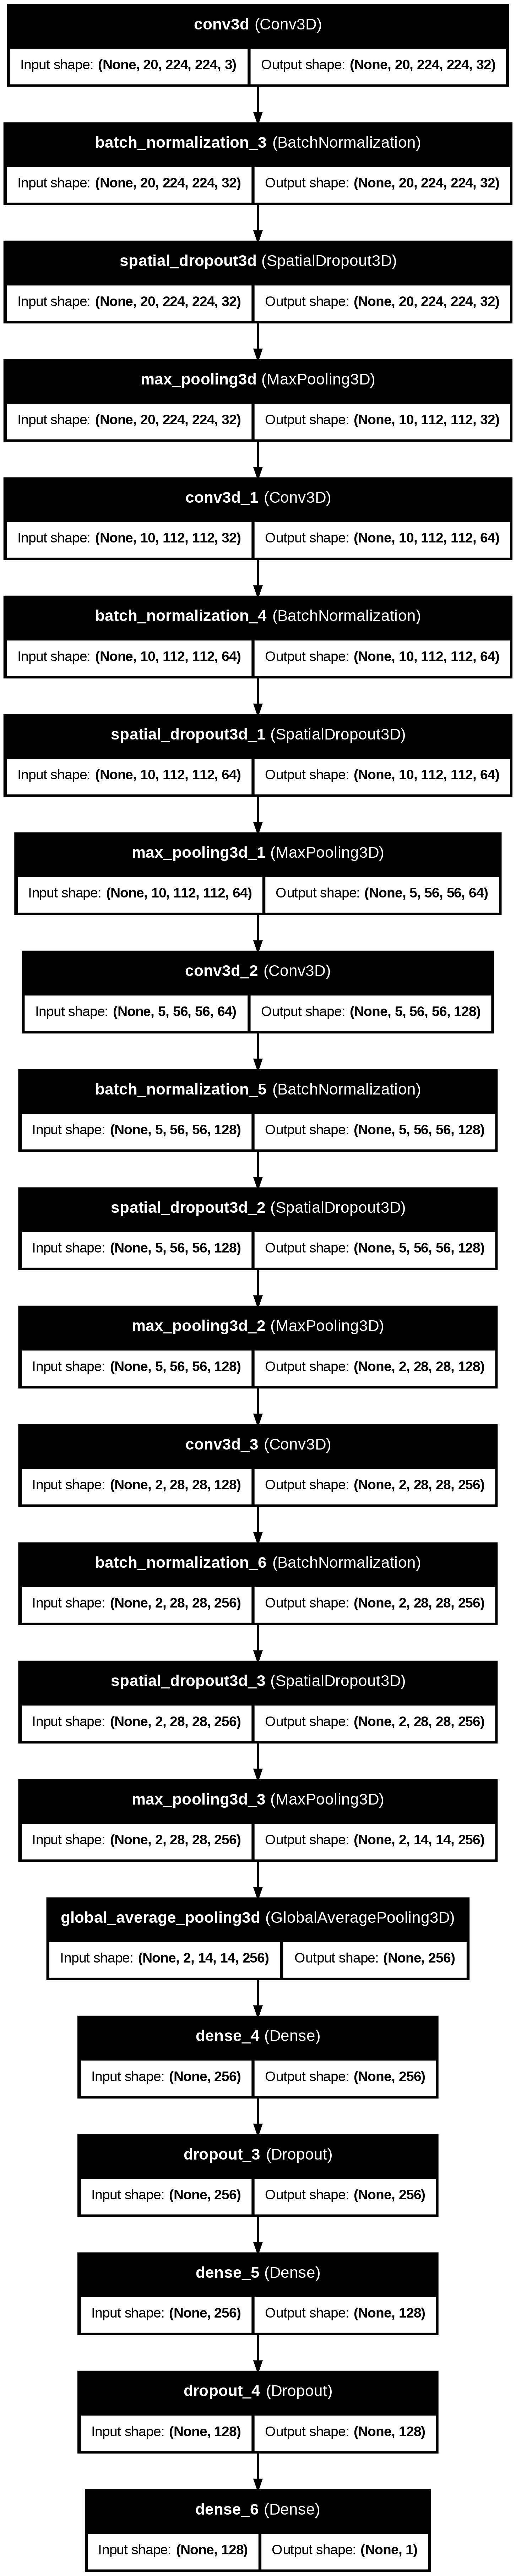

In [ ]:
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# **Evaluating 📈**

In [ ]:
test_loss, test_accuracy= model.evaluate(test_sequence_gen, steps=10)
print(f"Test Accuracy: {test_accuracy}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 899ms/step - accuracy: 0.3893 - loss: 0.7840
Test Accuracy: 0.5


In [ ]:
print(f"Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")

Training Accuracy: 0.5078125
Validation Accuracy: 0.5546875


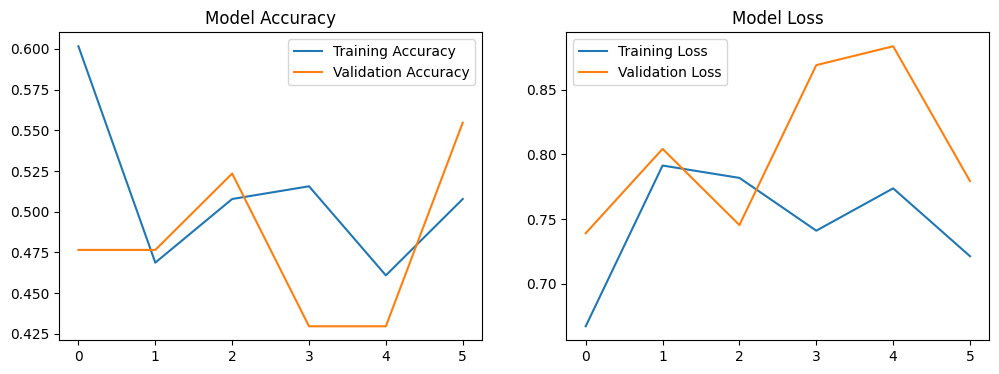

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(test_sequence_gen, steps=10)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 984ms/step


In [ ]:
y_true = []
for i in range(10):
  _, batch_labels = next(test_sequence_gen)
  y_true.extend(batch_labels)

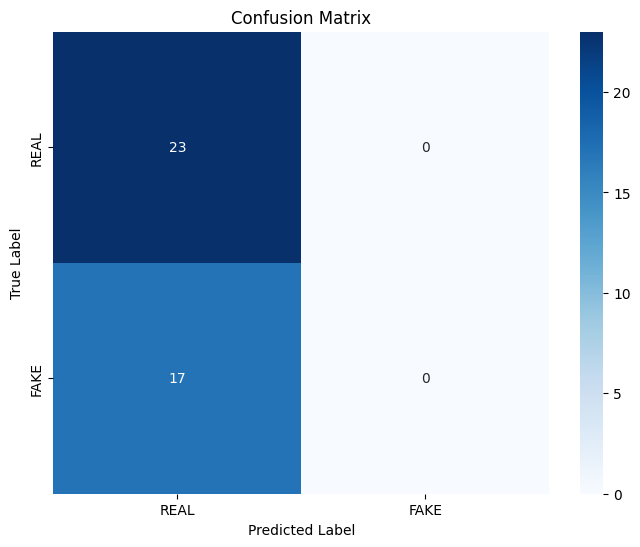

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

---

# **Fine tuning VGG 16 🧠**

---

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.001),
              kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)

x = Dense(512, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.001),
              kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.001),
              kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

output = Dense(1, activation='sigmoid')(x)

In [ ]:
model_vgg = Model(inputs=base_model.input, outputs=output)

In [ ]:
model_vgg.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'],)

# **Training 🚀**

In [ ]:
history = model_vgg.fit(
    train_generator,
    validation_data=vali_generator,
    epochs=100,
    steps_per_epoch= 64,
    validation_steps= 64,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.5892 - loss: 4.3920 - val_accuracy: 0.4560 - val_loss: 3.9736 - learning_rate: 0.0100
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 446ms/step - accuracy: 0.6420 - loss: 2.7402 - val_accuracy: 0.6200 - val_loss: 2.1940 - learning_rate: 0.0100
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 59s 858ms/step - accuracy: 0.6600 - loss: 1.9576 - val_accuracy: 0.6520 - val_loss: 1.6467 - learning_rate: 0.0100
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 466ms/step - accuracy: 0.6425 - loss: 1.5796 - val_accuracy: 0.7200 - val_loss: 1.4230 - learning_rate: 0.0100
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 59s 858ms/step - accuracy: 0.6538 - loss: 1.4113 - val_accuracy: 0.6793 - val_loss: 1.2738 - learning_rate: 0.0100
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 463ms/step - accuracy: 0.6601 - loss: 1.2578 - val_accuracy: 0.6720 - val_loss: 1.1637 - learning_rate: 0.0100
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 843ms/step - accuracy: 0.6831 - loss: 1.1831 - val_accuracy: 0.7160 - val_loss: 1.1271 - learning_rate: 0.0100
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 459ms/step - accuracy: 0.6604 - loss: 1.1721 

# **Evaluating 📈**

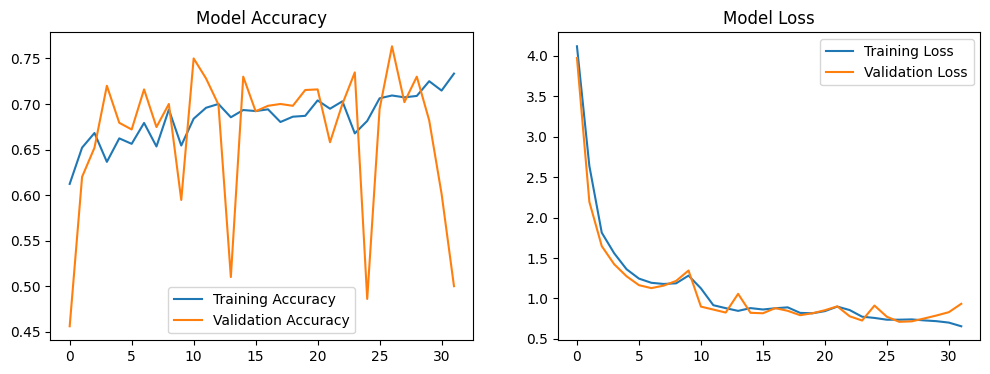

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [ ]:
for layer in base_model.layers[-4:]:
        layer.trainable = True

In [ ]:
fine_tune_lr = 1e-5

In [ ]:
model_vgg.compile(
        optimizer=Adam(learning_rate=fine_tune_lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

# **Training 🚀**

In [ ]:
fine_tune_history = model_vgg.fit(
        train_generator,
        validation_data=vali_generator,
        epochs=50,
        steps_per_epoch=64,
        validation_steps=64,
            callbacks=[early_stopping, reduce_lr]
    )

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 69s 878ms/step - accuracy: 0.7147 - loss: 0.7163 - val_accuracy: 0.7553 - val_loss: 0.6935 - learning_rate: 1.0000e-05
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 34s 544ms/step - accuracy: 0.7389 - loss: 0.7115 - val_accuracy: 0.7533 - val_loss: 0.6906 - learning_rate: 1.0000e-05
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 57s 825ms/step - accuracy: 0.7115 - loss: 0.7255 - val_accuracy: 0.7353 - val_loss: 0.6902 - learning_rate: 1.0000e-05
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 443ms/step - accuracy: 0.7357 - loss: 0.6971 - val_accuracy: 0.7667 - val_loss: 0.6669 - learning_rate: 1.0000e-05
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 57s 833ms/step - accuracy: 0.7581 - loss: 0.6642 - val_accuracy: 0.7667 - val_loss: 0.6501 - learning_rate: 1.0000e-05
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 453ms/step - accuracy: 0.7495 - loss: 0.6785 - val_accuracy: 0.7573 - val_loss: 0.6727 - learning_rate: 1.0000e-05
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 57s 825ms/step - acc

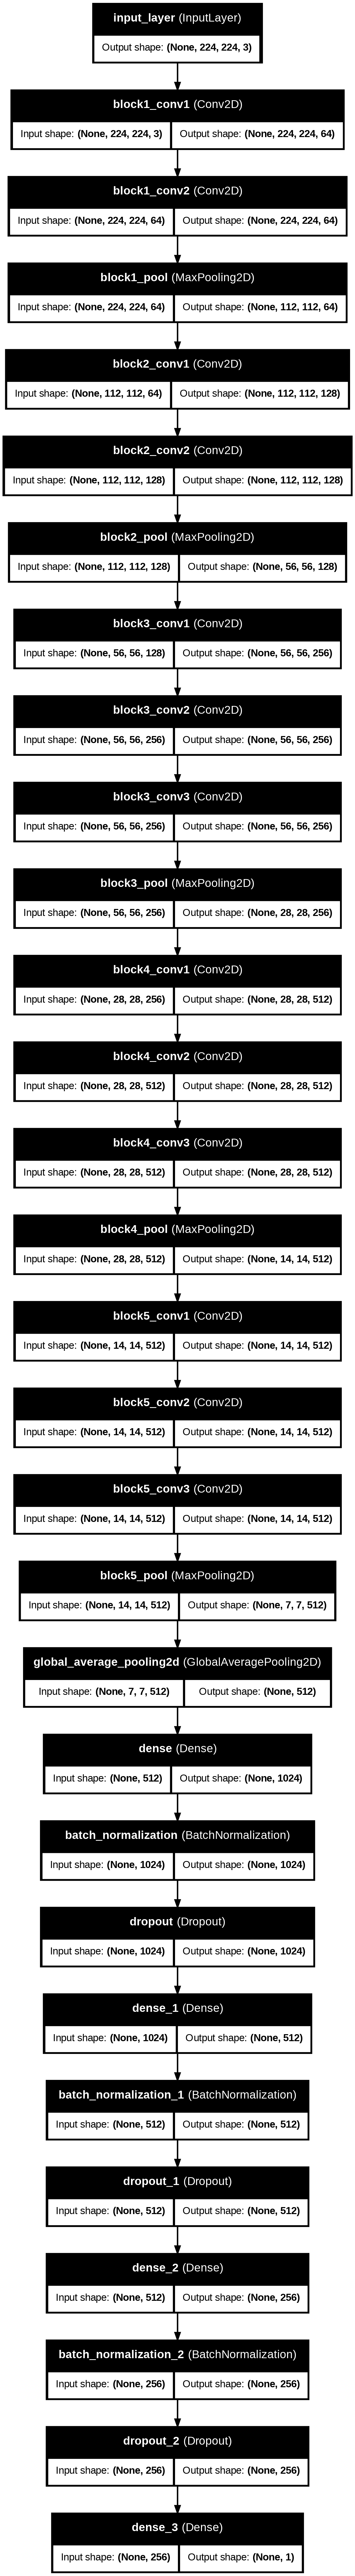

In [ ]:
plot_model(model_vgg, to_file='modelVGG_architecture.png', show_shapes=True, show_layer_names=True)

# **Evlauting 📈**

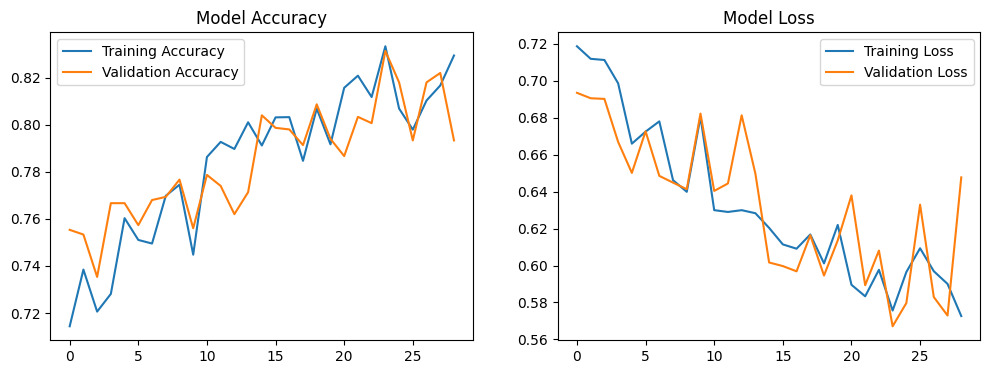

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(fine_tune_history.history['accuracy'], label='Training Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(fine_tune_history.history['loss'], label='Training Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [ ]:
def single_image_generator(sequence_gen):
    for sequences, labels in sequence_gen:
        images = sequences.reshape(-1, 224, 224, 3)
        yield images, labels

In [ ]:
test_single_gen = single_image_generator(test_generator)

In [ ]:
test_loss, test_accuracy = model_vgg.evaluate(test_single_gen, steps=10)
print(f"Test Accuracy: {test_accuracy}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - accuracy: 0.8444 - loss: 0.5467
Test Accuracy: 0.8374999761581421


In [ ]:
print(f"Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")

Training Accuracy: 0.7333333492279053
Validation Accuracy: 0.5


In [ ]:
y_pred = model_vgg.predict(test_single_gen, steps=10)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 297ms/step


In [ ]:
y_true = []
for i in range(10):
       _, batch_labels = next(test_single_gen)
       y_true.extend(batch_labels)

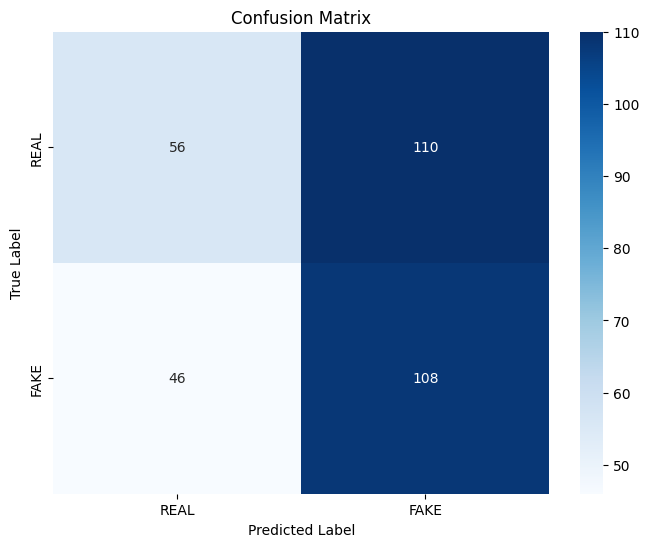

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()